In [93]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

import pickle

import matplotlib as mpl

pb.ion()

file_base = ""

In [94]:
X_raw = np.load("hc_G6_test.npy", allow_pickle=True)
Y_raw = np.load("samples_G6_test.npy", allow_pickle=True)
# Emulator version label, for plots
emu_vlabel = "G7a"

In [95]:
scales = np.load("../standard_k.npy", allow_pickle=True)

In [96]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [97]:
m = pickle.load(open("analyses/massive_emulator_" + emu_vlabel + ".nucomet", "rb"))

In [98]:
def inverse_ytransform(raw_prediction):
    return np.exp(raw_prediction * m.ystdev + m.ymu)

In [99]:
#def xtransform(configuration):
#    return (configuration - m.xmu) / m.xstdev

def xtransform(configuration):
    return (configuration - m.xmu) / m.xstdev

In [100]:
def nest(array):
    return np.array([np.array(array)])

In [101]:
preds = np.zeros(Y.shape)
rel_errors = np.zeros(Y.shape)
sq_errors = np.zeros(Y.shape)

for i in range(len(X)):
    x = xtransform(nest(X[i]))
    raw_pred, _ = m.predict(x)
    preds[i] = inverse_ytransform(raw_pred)
    rel_errors[i] = (preds[i] - Y[i]) / Y[i]
    sq_errors[i] = np.square(preds[i] - Y[i])

In [102]:
print("Squared error across all models:")
print(sum(sum(sq_errors)))

Squared error across all models:
212194251.71253303


[2.15785750e-02 1.36177000e-01 9.73865000e-01 8.32239993e-01
 2.56269744e-09 6.73700000e-03]


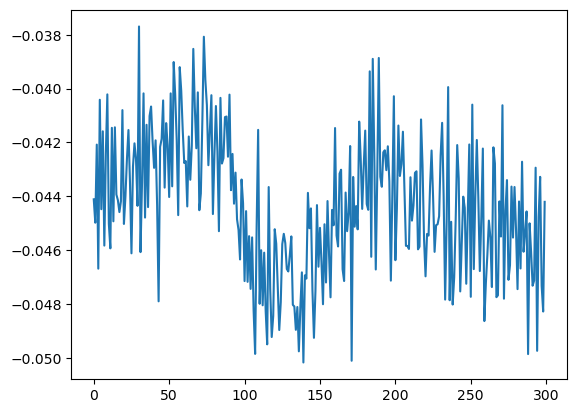

In [103]:
# An example of an extreme error plot, with the cosmology it was
# supposed to describe. 

pb.plot(rel_errors[900] * 100)
print(X[900])

In [104]:
min(X[:, 3])

0.20008000060333042

In [105]:
max(X[:, 3])

0.9999201620474477

In [106]:
def normalize(array):
    min_ = min(array)
    max_ = max(array)
    range_ = max_ - min_
    shifted = array - min_
    return shifted / range_

In [156]:
# Let's use the plasma color map
def plot_colored_errors(param_index, param_label, save_label=None):
    valids = np.where(np.logical_and(X[:, param_index] < 0.4, X[:, param_index] > 0.3))
    #print(valids[0])
    print(valids[0].shape)
    sigma12s = X[:, param_index][valids[0]]
    normalized_vals = normalize(sigma12s)
    # normalized_vals = normalize(X[:, param_index])
    colors = pb.cm.plasma(normalized_vals)

    valid_errors = rel_errors[valids[0]]
    
    for i in range(len(colors)):
        if i % 1 == 0:
            pb.plot(scales, 100 * valid_errors[i],
                color=colors[i], alpha=0.05)
            pb.xscale('log')

    pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" + 
            "\ncolored by " + param_label + " value")
    pb.ylabel("% error between CAMB and CassL")
    pb.xlabel("scale $k$ [1 / Mpc]")
    #norm = mpl.colors.Normalize(
    #    vmin=min(X[:, param_index]), vmax=max(X[:, param_index]))
    norm = mpl.colors.Normalize(
        vmin=min(X[:, param_index][valids[0]]),
        vmax=max(X[:, param_index][valids[0]]))
    pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma, norm=norm))
    # Momentarily eliminate saving so that we don't keep crashing on the
    # incomplete file handles.
    if save_label is not None:
        pb.savefig("../../plots/emulator/performance/" + save_label + ".png")

(625,)


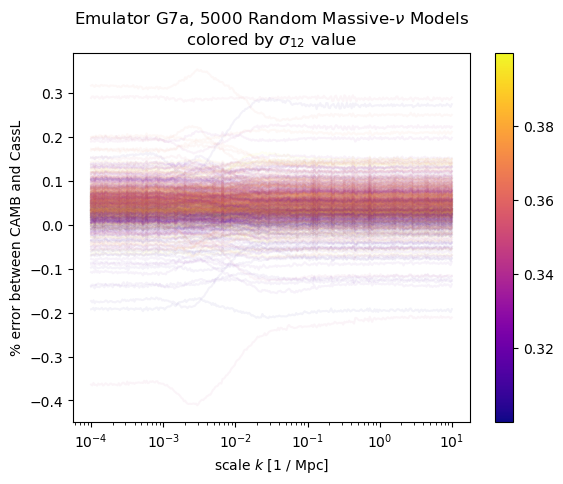

In [157]:
plot_colored_errors(3, r"$\sigma_{12}$", save_label="s12_coloration")

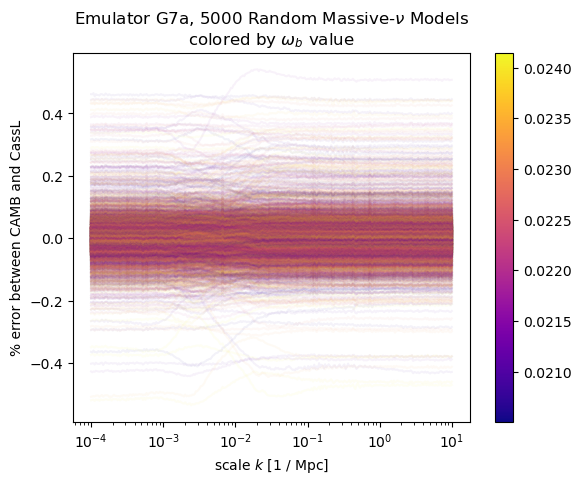

In [109]:
plot_colored_errors(0, r"$\omega_b$")

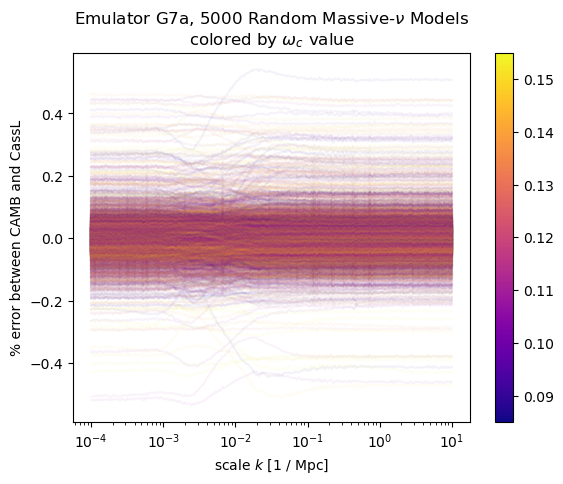

In [110]:
plot_colored_errors(1, r"$\omega_c$")

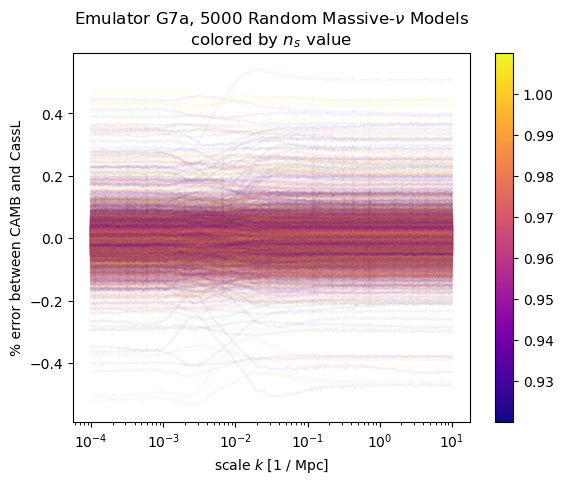

In [111]:
plot_colored_errors(2, r"$n_s$")

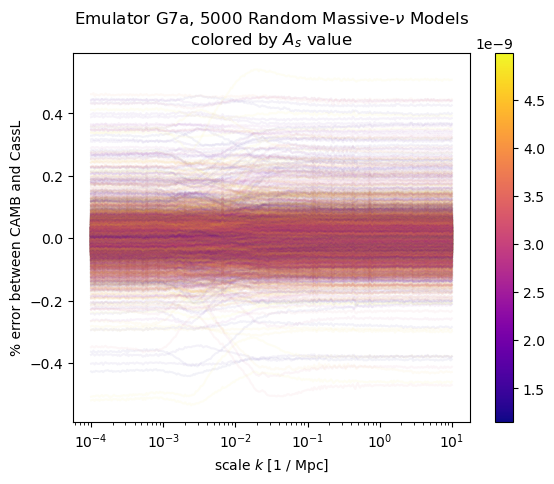

In [112]:
plot_colored_errors(4, r"$A_s$", "_colored_by_As")

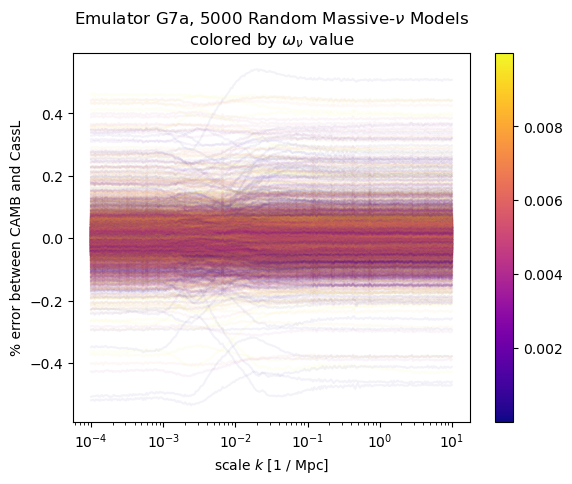

In [113]:
plot_colored_errors(5, r"$\omega_\nu$", "_colored_by_omnu")

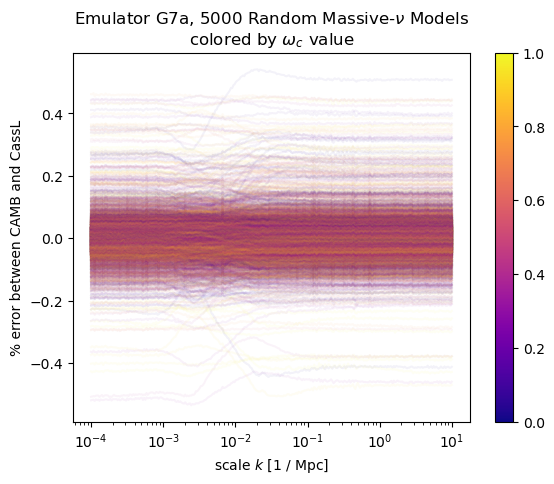

In [114]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

# Let's use the plasma color map
normalized_omc_vals = normalize(X[:, 1])
colors_omc = pb.cm.plasma(normalized_omc_vals)

for i in range(len(rel_errors)):
    if i % 1 == 0:
        pb.plot(scales, 100 * rel_errors[i],
            color=colors_omc[i], alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_c$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma))
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

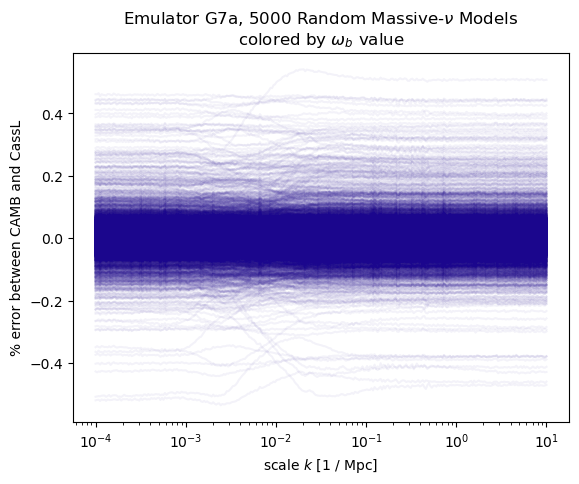

In [115]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color=pb.cm.plasma(X[i][0]), alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_b$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

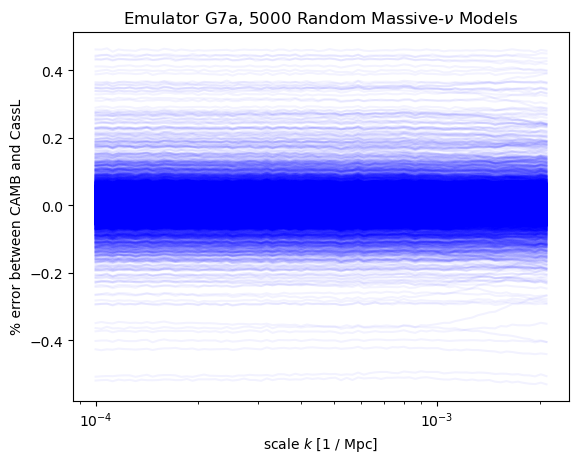

In [116]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales[:80], 100 * rel_errors[i][:80],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

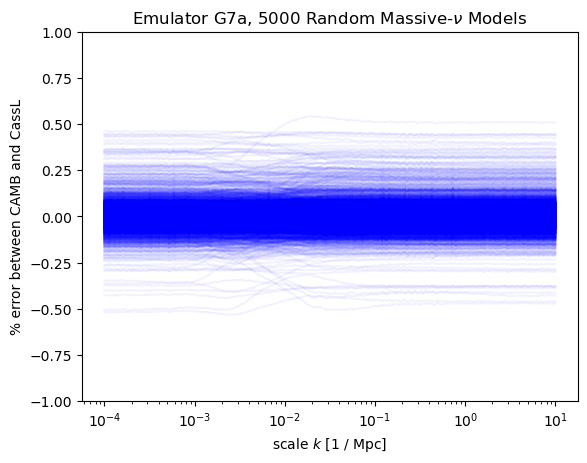

In [117]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color='blue', alpha=0.05)
        pb.xscale('log')

pb.ylim((-1, 1))        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.savefig("../../plots/emulator/performance/massive_5k_" + emu_vlabel + ".png")

In [118]:
# Error statistics ideas: parentheticals describe building blocks

# (for each curve:)
    # a minimum percent error
    # b maximum percent error
    # c standard deviation of errors
    # d mean error
    # e median error

# Median, mean, stddev of a-e.

mins = np.array([min(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MINIMUM RELATIVE ERRORS:")
print("this ranges from", min(mins), "to", max(mins))
print("median is", np.median(mins))
print("mean is", np.mean(mins))
print("st.dev. is", np.std(mins))

MINIMUM RELATIVE ERRORS:
this ranges from 5.119798375174337e-10 to 0.004384547653767897
median is 0.0001750656828168262
mean is 0.0002889398881773312
st.dev. is 0.00041885622002628094


In [119]:
maxs = np.array([max(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MAXIMUM RELATIVE ERRORS:")
print("this ranges from", min(maxs), "to", max(maxs))
print("median is", np.median(maxs))
print("mean is", np.mean(maxs))
print("st.dev. is", np.std(maxs))

MAXIMUM RELATIVE ERRORS:
this ranges from 5.862696181092463e-05 to 0.0054157941320628605
median is 0.0004202464190081967
mean is 0.0005488681458389031
st.dev. is 0.0004996885389329307


In [120]:
means = np.array([np.mean(rel_error_curve) for rel_error_curve in rel_errors])
print("MEAN RELATIVE ERRORS:")
print("this ranges from", min(means), "to", max(means))
print("median is", np.median(means))
print("mean is", np.mean(means))
print("st.dev. is", np.std(means))

MEAN RELATIVE ERRORS:
this ranges from -0.004767211418665392 to 0.0045151372045585635
median is 1.3391165757093114e-05
mean is 2.1427388525806095e-05
st.dev. is 0.000616698575008996


In [121]:
meds = np.array([np.median(rel_error_curve) for rel_error_curve in rel_errors])
print("MEDIAN RELATIVE ERRORS:")
print("this ranges from", min(meds), "to", max(meds))
print("median is", np.median(meds))
print("mean is", np.mean(meds))
print("st.dev. is", np.std(meds))

MEDIAN RELATIVE ERRORS:
this ranges from -0.004693798809697069 to 0.005068235883785617
median is 1.2021814160791044e-05
mean is 2.3028188540830874e-05
st.dev. is 0.0006298704532878594


In [122]:
stddevs = np.array([np.std(rel_error_curve) for rel_error_curve in rel_errors])
print("ST.DEV.S IN RELATIVE ERRORS:")
print("this ranges from", min(stddevs), "to", max(stddevs))
print("median is", np.median(stddevs))
print("mean is", np.mean(stddevs))
print("st.dev. is", np.std(stddevs))

ST.DEV.S IN RELATIVE ERRORS:
this ranges from 1.807786367769579e-05 to 0.0013409311531139287
median is 4.737380981788001e-05
mean is 7.126297315368927e-05
st.dev. is 8.458480766757274e-05


(array([4014.,  663.,  192.,   55.,   32.,   16.,    9.,    7.,    7.,
           5.]),
 array([5.11979838e-10, 4.38455226e-04, 8.76909940e-04, 1.31536465e-03,
        1.75381937e-03, 2.19227408e-03, 2.63072880e-03, 3.06918351e-03,
        3.50763823e-03, 3.94609294e-03, 4.38454765e-03]),
 <BarContainer object of 10 artists>)

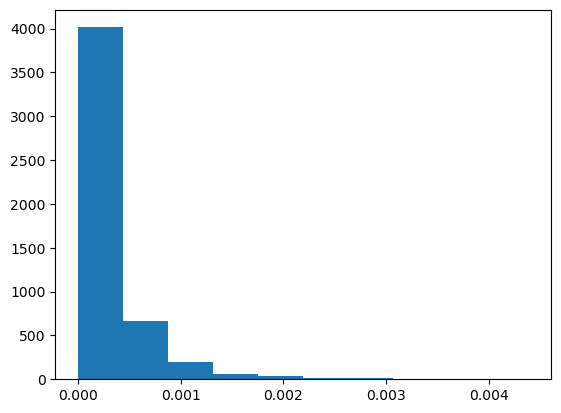

In [123]:
pb.hist(mins)

(array([3577., 1011.,  249.,   78.,   38.,   16.,   12.,    8.,    7.,
           4.]),
 array([5.86269618e-05, 5.94343679e-04, 1.13006040e-03, 1.66577711e-03,
        2.20149383e-03, 2.73721055e-03, 3.27292726e-03, 3.80864398e-03,
        4.34436070e-03, 4.88007742e-03, 5.41579413e-03]),
 <BarContainer object of 10 artists>)

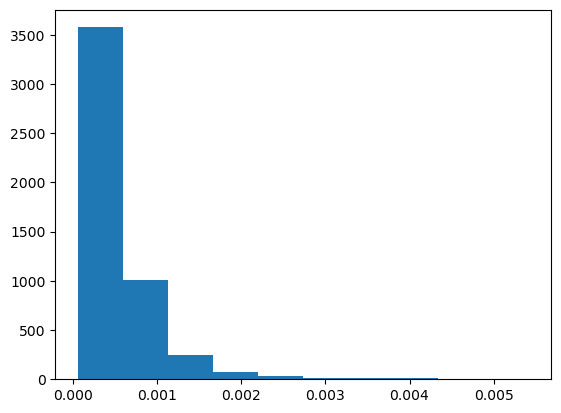

In [124]:
pb.hist(maxs)

(array([4.60e+03, 2.81e+02, 6.10e+01, 2.60e+01, 1.30e+01, 8.00e+00,
        4.00e+00, 5.00e+00, 1.00e+00, 1.00e+00]),
 array([1.80778637e-05, 1.50363193e-04, 2.82648522e-04, 4.14933851e-04,
        5.47219179e-04, 6.79504508e-04, 8.11789837e-04, 9.44075166e-04,
        1.07636050e-03, 1.20864582e-03, 1.34093115e-03]),
 <BarContainer object of 10 artists>)

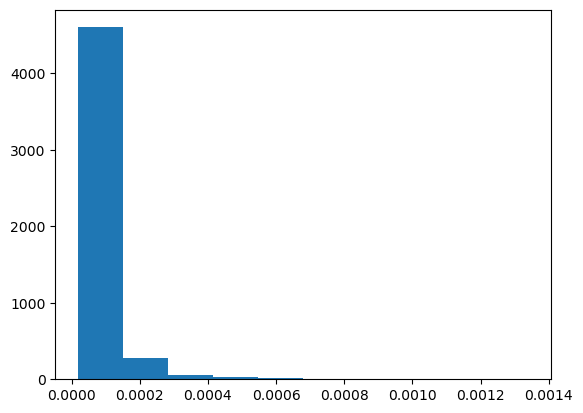

In [125]:
pb.hist(stddevs)

(array([   8.,    3.,   19.,  277., 2908., 1634.,   99.,   31.,   15.,
           6.]),
 array([-0.0046938 , -0.0037176 , -0.00274139, -0.00176519, -0.00078898,
         0.00018722,  0.00116342,  0.00213963,  0.00311583,  0.00409203,
         0.00506824]),
 <BarContainer object of 10 artists>)

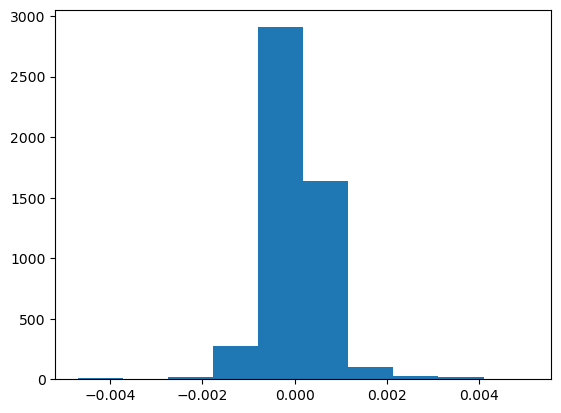

In [126]:
pb.hist(meds)

(array([   5.,    4.,   12.,  140., 1770., 2796.,  203.,   43.,   17.,
          10.]),
 array([-0.00476721, -0.00383898, -0.00291074, -0.00198251, -0.00105427,
        -0.00012604,  0.0008022 ,  0.00173043,  0.00265867,  0.0035869 ,
         0.00451514]),
 <BarContainer object of 10 artists>)

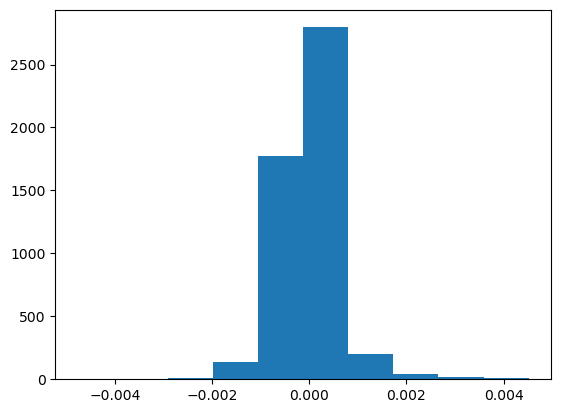

In [127]:
pb.hist(means)